In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout2d
from torch.optim import Adam, SGD
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from skimage.transform import rotate, AffineTransform, warp
import skimage.io as io
import ctypes
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from random import random
np.set_printoptions(threshold=np.inf)

In [2]:
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.load('brain_tumor_dataset/images.npy')
masks = np.load('brain_tumor_dataset/masks.npy')
img = []
lab = []
for itr in tqdm(range(len(labels))):
    temp = []
    temp.append(images[itr,:,:])
    img.append(temp)
    lab.append(labels[itr])
    
    temp = []
    temp.append(np.fliplr(images[itr,:,:]))
    img.append(temp)
    lab.append(labels[itr])
    
    temp = []
    temp.append(cv2.rotate(images[itr,:,:], cv2.ROTATE_180))
    img.append(temp)
    lab.append(labels[itr])
    
img = np.array(img)
lab = np.array(lab)
lab = lab.astype(int)

class TrainHelper(Dataset):
    def __init__(self):
        self.len = img.shape[0]
        self.img, self.lab = img.astype('float32'), lab.astype('float32')
        self.img = torch.from_numpy(img)
        self.lab = torch.from_numpy(lab)
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.img[idx], self.lab[idx]
traindataset = TrainHelper()
train_loader = DataLoader(dataset = traindataset, batch_size=32,shuffle=True,num_workers=0)

100%|██████████| 3064/3064 [00:00<00:00, 38944.78it/s]


Loading the trained model from Notebook 2 and 3

In [3]:
class Net2(Module):   
    def __init__(self):
        super(Net2, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 64, kernel_size=10, stride=1, padding=0),
            ReLU(inplace=True),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout2d(0.10),
            
            Conv2d(128, 256, kernel_size=2, stride=1, padding=2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),         
            Dropout2d(0.20),
            
            Conv2d(256,12544, kernel_size=7, padding=0),   # This tenique is called fully connected layer using convulation layer.
            ReLU(inplace=True),
            
            Conv2d(12544, 4, kernel_size=1),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        return x

In [4]:
model = Net2()
model.load_state_dict(torch.load('50x50VA98.76epoch94k.pth'))

<All keys matched successfully>

taking a sample prediction for visualization

In [5]:
a,b = next(iter(train_loader))
out50 = model(a.float())
out50 = F.softmax(out50,dim=1)

In [6]:
print(out50.shape)

torch.Size([32, 4, 10, 10])


discussing for model<br>
Output is of size 32x4x10x10 <br>
32 is number of input images
4 is number of classes <br> 1<sup>st</sup> class represent null class(this region does not represent cancer cell) 3 type of cancer are next 3 classes<br>
10x10 is a image denoting the probablity of label (l) for that particular class 

The cell below is the visual representation of the above statement for the first five datapoints. <br>
Yellow denotes high value, near to one. Black represents small value near to zero
It is to note that plt.imshow converts probablity 0-1 to 0-255. <br>So, two same colour in different images might represent different values

Class Label  1


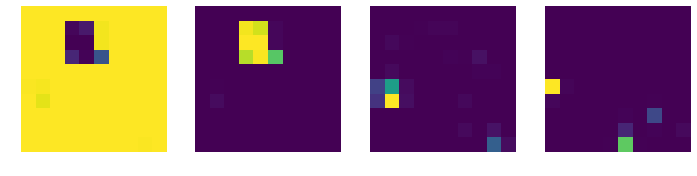

Class Label  3


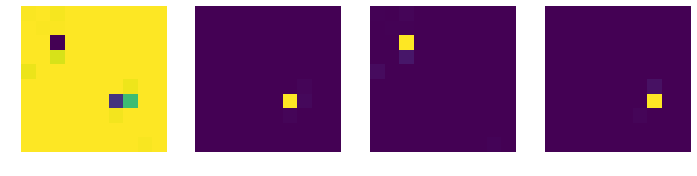

Class Label  3


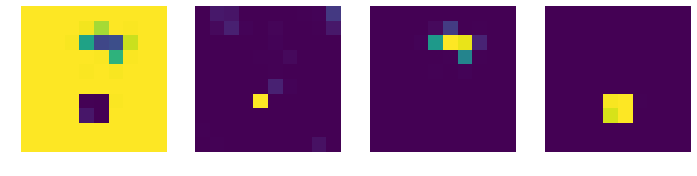

Class Label  3


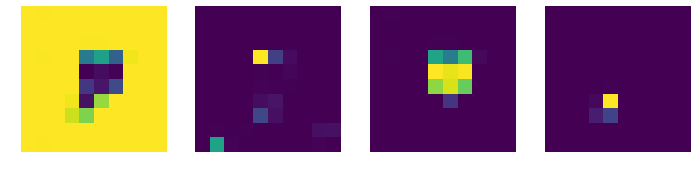

Class Label  1


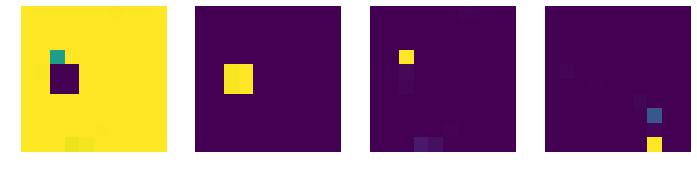

Class Label  2


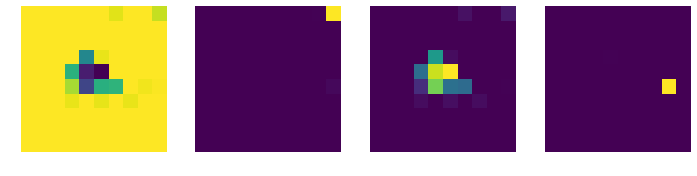

Class Label  3


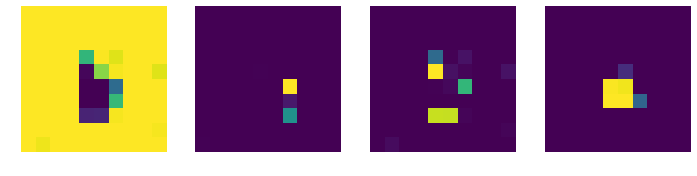

Class Label  3


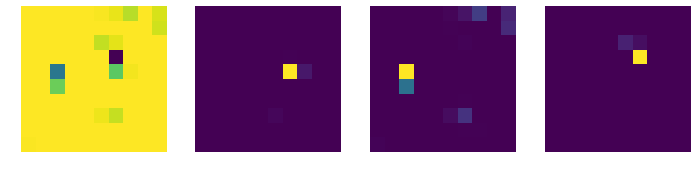

Class Label  2


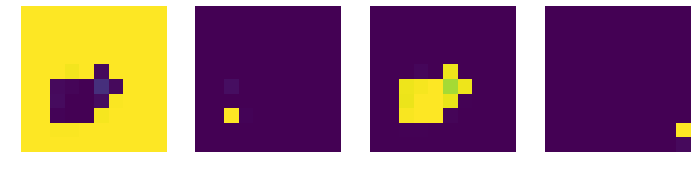

Class Label  3


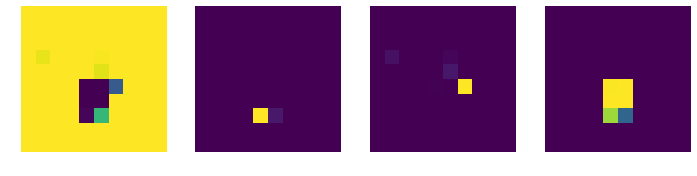

Class Label  3


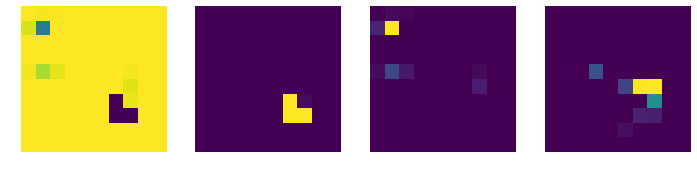

Class Label  1


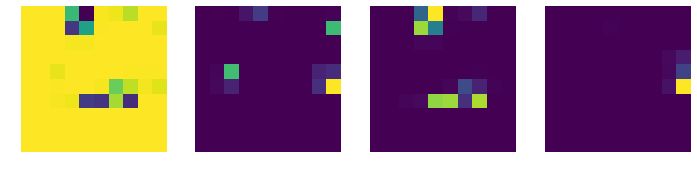

Class Label  2


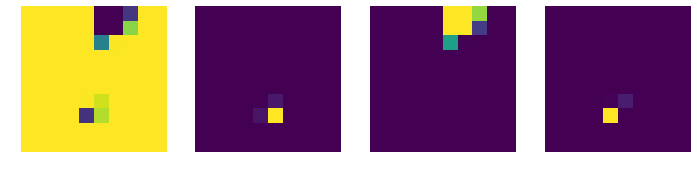

Class Label  1


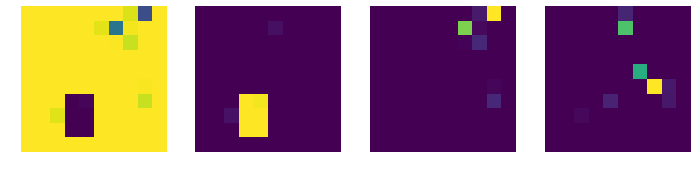

Class Label  3


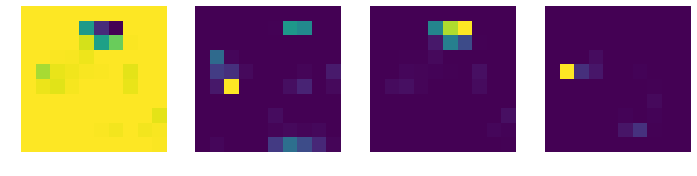

Class Label  2


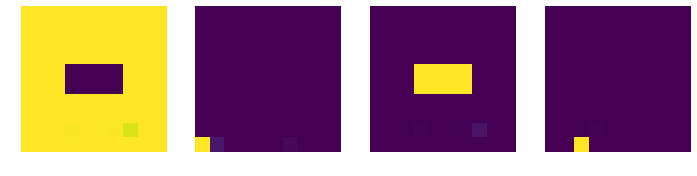

Class Label  1


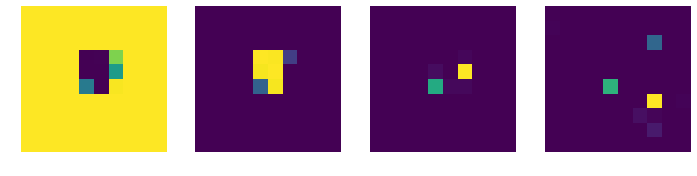

Class Label  2


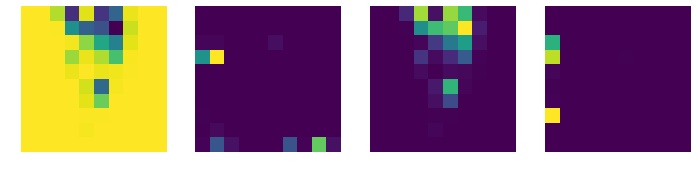

Class Label  2


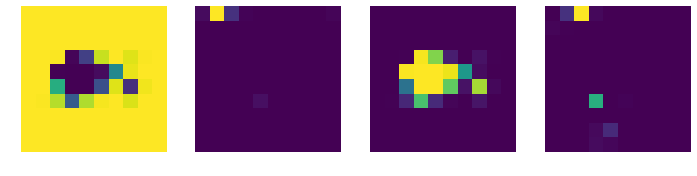

Class Label  3


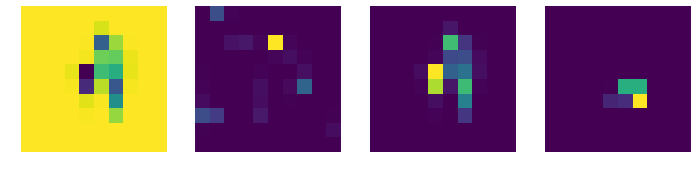

Class Label  2


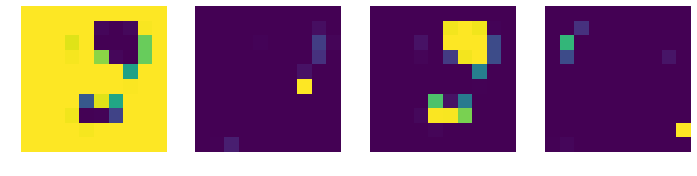

Class Label  1


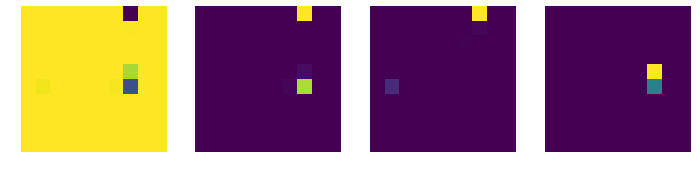

Class Label  3


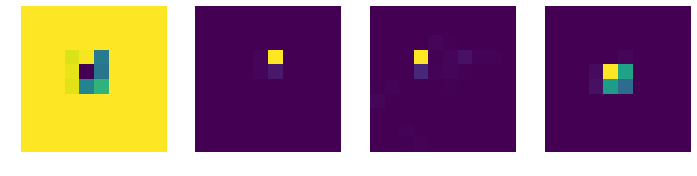

Class Label  1


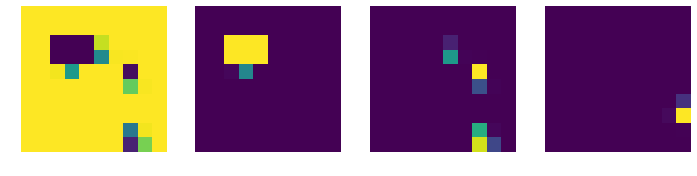

Class Label  2


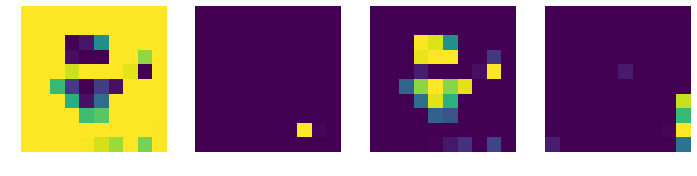

Class Label  2


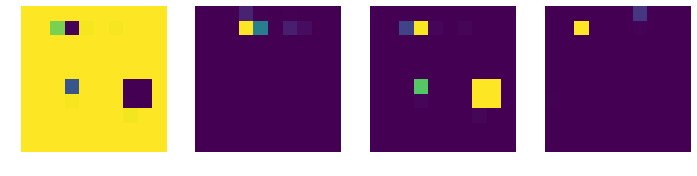

Class Label  3


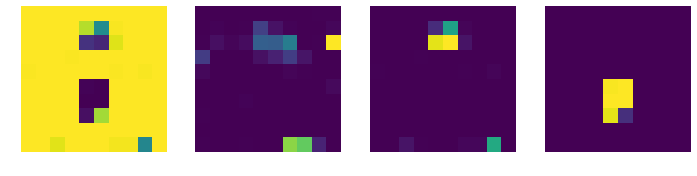

Class Label  2


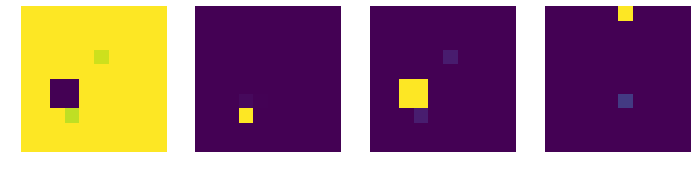

Class Label  2


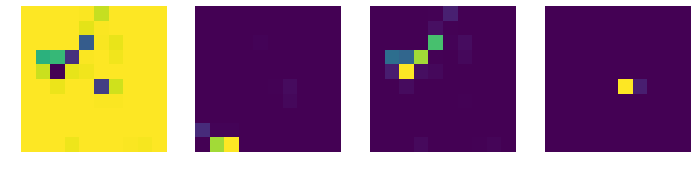

Class Label  2


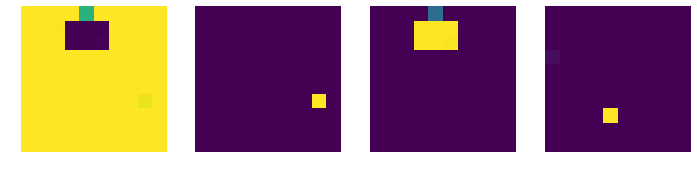

Class Label  2


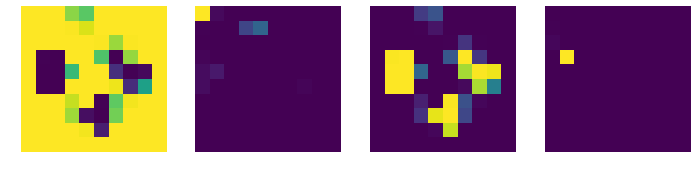

Class Label  2


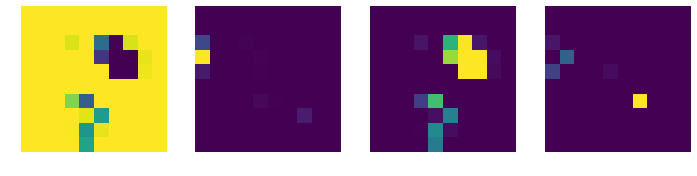

In [7]:
for x in range(0,32):
    for i in range(x,x+1):
        print("Class Label ", b[i].item())
        fig = plt.figure(figsize=(12,12))
        ax1 = fig.add_subplot(1,4,1)
        ax1.axis('off')
        ax1.imshow(out50[i,0,:,:].detach().numpy())
        ax1 = fig.add_subplot(1,4,2)
        ax1.axis('off')
        ax1.imshow(out50[i,1,:,:].detach().numpy())
        ax1 = fig.add_subplot(1,4,3)
        ax1.axis('off')
        ax1.imshow(out50[i,2,:,:].detach().numpy())
        ax1 = fig.add_subplot(1,4,4)
        ax1.axis('off')
        ax1.imshow(out50[i,3,:,:].detach().numpy())
        ax1.axis('off')
        plt.show()